In [40]:
import torch 
import torch
from torch_geometric.data import Data, Dataset
import networkx as nx
import random

ModuleNotFoundError: No module named 'torch_geometric'

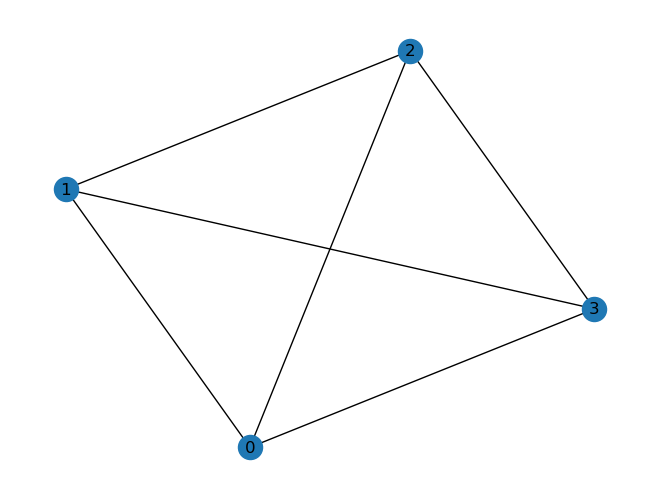

In [41]:
def create_initial_graph(n, k):
    """Create an initial graph with a cycle of size k."""
    G = nx.cycle_graph(k)
    G.add_nodes_from(range(k, n))
    return G

def is_valid_transition(G, u, v, k):
    """Check if adding or removing an edge preserves the cycle of size k."""
    if G.has_edge(u, v):
        G.remove_edge(u, v)
        has_cycle = any(len(cycle) == k for cycle in nx.simple_cycles(G))
        G.add_edge(u, v)
        return has_cycle
    else:
        G.add_edge(u, v)
        all_cycles = list(nx.simple_cycles(G))
        G.remove_edge(u, v)
        return all(len(cycle) == k or len(cycle) < k for cycle in all_cycles)

def connect_components(G):
    """Randomly connect all components of the graph."""
    components = list(nx.connected_components(G))
    while len(components) > 1:
        # Randomly select two components
        c1, c2 = random.sample(components, 2)
        
        # Random nodes from each component
        n1, n2 = random.choice(list(c1)), random.choice(list(c2))
        
        # Connect these nodes
        G.add_edge(n1, n2)
        
        # Update components
        components = list(nx.connected_components(G))

def mcmc_graph_generation(n, k, steps=100):
    """Generate a graph using MCMC."""
    G = create_initial_graph(n, k)

    nodes = list(G.nodes())

    for i in range(steps):
        u, v = random.sample(nodes, 2)
        
        if is_valid_transition(G, u, v, k):
            if G.has_edge(u, v):
                G.remove_edge(u, v)
            else:
                G.add_edge(u, v)
        
    connect_components(G)
    return G

# Example usage


# Visualize the graph
nx.draw(graph, with_labels=True)


In [42]:
graph_list = []
for n in range(3, 21):
    for k in range(3, 8):
        if n < k:
            continue
        graph = mcmc_graph_generation(n, k)
        graph_list.append(graph)

In [44]:
def convert_to_pyg_data(graph, num_node_features):
    edge_index = torch.tensor(list(graph.edges()), dtype=torch.long).t().contiguous()
    x = torch.ones(graph.number_of_nodes(), num_node_features)  # Example node features
    return Data(x=x, edge_index=edge_index)

# Assume 'graph_list' is your list of NetworkX graphs
num_node_features = 1  # Define the number of node features
pyg_data_list = [convert_to_pyg_data(graph, num_node_features) for graph in graph_list]

NameError: name 'Data' is not defined

In [ ]:
class CyclicGraphDataset(Dataset):
    def __init__(self, data_list):
        super(CyclicGraphDataset, self).__init__()
        self.data_list = data_list

    def len(self):
        return len(self.data_list)

    def get(self, idx):
        return self.data_list[idx]

# Create the dataset
dataset = CyclicGraphDataset(pyg_data_list)
torch.save(dataset, 'cyclic_dataset.pt')